# 04 Sentinel-2 vegetation indices over Camargue

## Quick link
 
* [Objective](#objective)
* [Test Site](#test-site)
* [Context](#context)
* [Applicability](#applicability)
* [Data](#data)
* [Workflow](#workflow)
* [License](#license)

## <a name="objective">Objective 

The objective is to generate three vegetation indices derived from Sentinel-2 data:

| Vegetation index | Formulation     | S-2 bands used      |
|------------------|-----------------|---------------------|
| NDVI             | (NIR-R)/(NIR+R) | (B7 − B4)/(B7 + B4) |
| NDI45            | (NIR-R)/(NIR+R) | (B5 − B4)/(B5 + B4) |
| GNDVI            | (NIR−G)/(NIR+G) | (B7 − B3)/(B7 − B3) |

## <a name="testsite">Test Site

Camargue - France

## <a name="context">Context

Vegetation indices are a spectral transformation of two or more bands designed to enhance the contribution of vegetation properties and allow reliable spatial and temporal inter-comparisons of terrestrial photosynthetic activity and canopy structural variations.

## <a name="applicability">Applicability

This practice can be applied globally. 

## <a name="data">Data

SENTINEL data products are made available systematically and free of charge to all data users including the general public, scientific and commercial users. Radar data will be delivered within an hour of reception for Near Real-Time (NRT) emergency response, within three hours for NRT priority areas and within 24 hours for systematically archived data.

All data products are distributed in the SENTINEL Standard Archive Format for Europe (SAFE) format.

The data used are Sentinel-2 Level-1C products: Top of atmosphere reflectances in fixed cartographic geometry (combined UTM projection and WGS84 ellipsoid). Level-1C images are a set of tiles of 100 sq km, each of which is approximately 500 MB. These products contain applied radiometric and geometric corrections (including orthorectification and spatial registration). 

The spectral bands of Sentinel-2 Level-1C products are:

| S-2 band                | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 8a  | 9   | 10   | 11   | 12   |
|-------------------------|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|------|------|------|
| Central wavelength (nm) | 443 | 490 | 560 | 665 | 705 | 740 | 783 | 842 | 865 | 945 | 1375 | 1610 | 2190 |
| Bandwidth (nm)          | 20  | 65  | 35  | 30  | 15  | 15  | 20  | 115 | 20  | 20  | 30   | 90   | 180  |
| Spatial resolution (m)  | 60  | 10  | 10  | 10  | 20  | 20  | 20  | 10  | 20  | 60  | 60   | 20   | 20   |

## <a name="workflow">Workflow

Import all libraries needed:

In [1]:
from snappy import jpy
from snappy import GPF
from snappy import HashMap
from snappy import ProductIO
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

We will use a Sentinel-2 product with a single granule:

In [2]:
s2path = "S2A_OPER_PRD_MSIL1C_PDMC_20161119T215754_R081_V20161119T133222_20161119T133222"
s2meta = "S2A_OPER_MTD_SAFL1C_PDMC_20161119T215754_R081_V20161119T133222_20161119T133222"

Open the product and get some information about it

In [3]:
s2prd = "/workspace/data/%s/%s.SAFE/%s.xml" % (s2path, s2path, s2meta)
product = ProductIO.readProduct(s2prd)

width = product.getSceneRasterWidth()
height = product.getSceneRasterHeight()
name = product.getName()
description = product.getDescription()
band_names = product.getBandNames()

In [4]:
print("Product: %s, %d x %d pixels" % (name, width, height))

Product: S2A_OPER_MTD_SAFL1C_PDMC_20161119T215754_R081_V20161119T133222_20161119T133222, 10980 x 10980 pixels


#### List the band names to create the arithmetic expressions

In [5]:
print("Bands:   %s" % (list(band_names)))

Bands:   ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B10', 'B11', 'B12', 'view_zenith_mean', 'view_azimuth_mean', 'sun_zenith', 'sun_azimuth', 'view_zenith_B1', 'view_azimuth_B1', 'view_zenith_B2', 'view_azimuth_B2', 'view_zenith_B3', 'view_azimuth_B3', 'view_zenith_B4', 'view_azimuth_B4', 'view_zenith_B5', 'view_azimuth_B5', 'view_zenith_B6', 'view_azimuth_B6', 'view_zenith_B7', 'view_azimuth_B7', 'view_zenith_B8', 'view_azimuth_B8', 'view_zenith_B8A', 'view_azimuth_B8A', 'view_zenith_B9', 'view_azimuth_B9', 'view_zenith_B10', 'view_azimuth_B10', 'view_zenith_B11', 'view_azimuth_B11', 'view_zenith_B12', 'view_azimuth_B12']


#### Resample the bands to a common resolution

In [6]:
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

HashMap = jpy.get_type('java.util.HashMap')

parameters = HashMap()
parameters.put('referenceBand', 'B7')

resample = GPF.createProduct('Resample', parameters, product)

#### Create the band arithmetic expressions

In [7]:
ndvi_expr = '(B7 + B4) != 0 ? (B7 - B4) / (B7 + B4) : -2'
ndi45_expr = '(B5 + B4) != 0 ? (B5 - B4) / (B5 + B4) : -2'
gndvi_expr = '(B7 + B3) != 0 ? (B7 - B3) / (B7 + B3) : -2'

Use the SNAP _BandMaths_ operator

In [8]:
BandDescriptor = jpy.get_type('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor')

targetBand1 = BandDescriptor()
targetBand1.name = 'ndvi'
targetBand1.type = 'float32'
targetBand1.expression = ndvi_expr

targetBand2 = BandDescriptor()
targetBand2.name = 'ndi45'
targetBand2.type = 'float32'
targetBand2.expression = ndi45_expr

targetBand3 = BandDescriptor()
targetBand3.name = 'gndvi'
targetBand3.type = 'float32'
targetBand3.expression = gndvi_expr

targetBands = jpy.array('org.esa.snap.core.gpf.common.BandMathsOp$BandDescriptor', 3)
targetBands[0] = targetBand1
targetBands[1] = targetBand2
targetBands[2] = targetBand3

parameters = HashMap()
parameters.put('targetBands', targetBands)

In [9]:
result = GPF.createProduct('BandMaths', parameters, resample)

### Plot the vegetation indices

We will use _matplotlib_ for plotting the vegetation indices


In [10]:
band1 = result.getBand('ndvi')
band2 = result.getBand('ndi45')
band3 = result.getBand('gndvi')

w = band1.getRasterWidth()
h = band1.getRasterHeight()

band1_data = np.zeros(w * h, np.float32)
band1.readPixels(0, 0, w, h, band1_data)

band2_data = np.zeros(w * h, np.float32)
band2.readPixels(0, 0, w, h, band2_data)

band3_data = np.zeros(w * h, np.float32)
band3.readPixels(0, 0, w, h, band3_data)

product.dispose()
result.dispose()

band1_data.shape = h, w
band2_data.shape = h, w
band3_data.shape = h, w

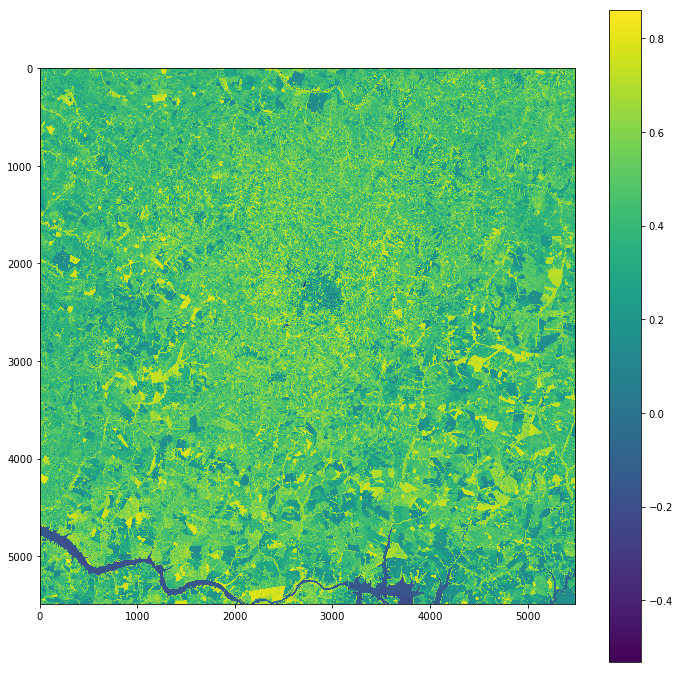

In [11]:
width = 12
height = 12
plt.figure(figsize=(width, height))
imgplot = plt.imshow(band1_data)
plt.colorbar()

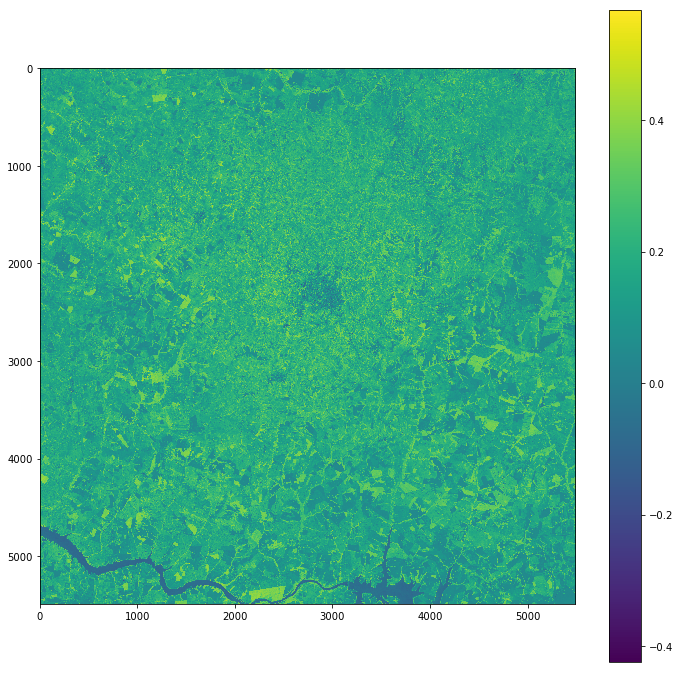

In [12]:
width = 12
height = 12
plt.figure(figsize=(width, height))
imgplot = plt.imshow(band2_data)
plt.colorbar()

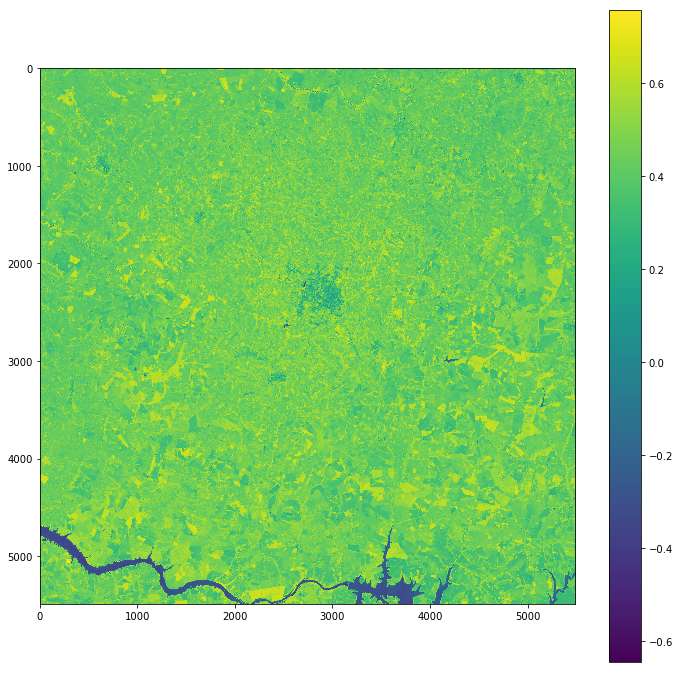

In [13]:
width = 12
height = 12
plt.figure(figsize=(width, height))
imgplot.set_cmap('spectral')
imgplot = plt.imshow(band3_data)
plt.colorbar()

## <a name="license">License

This work is licenced under a [Attribution-ShareAlike 4.0 International License (CC BY-SA 4.0)](http://creativecommons.org/licenses/by-sa/4.0/) 

YOU ARE FREE TO:

* Share - copy and redistribute the material in any medium or format.
* Adapt - remix, transform, and built upon the material for any purpose, even commercially.

UNDER THE FOLLOWING TERMS:

* Attribution - You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.
* ShareAlike - If you remix, transform, or build upon the material, you must distribute your contributions under the same license as the original.